In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import os
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import shutil
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

c:\Users\Dell\anaconda3\envs\ml\Lib\site-packages\torch\utils\_pytree.py:173: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
# Đưa model vào GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
print(os.path.exists(r'train'))

False


In [4]:
if not os.path.exists("data"):
    !git clone https://github.com/Bunhiacopxki/data.git

Cloning into 'data'...
Updating files:  17% (1441/8400)
Updating files:  18% (1512/8400)
Updating files:  19% (1596/8400)
Updating files:  20% (1680/8400)
Updating files:  21% (1764/8400)
Updating files:  22% (1848/8400)
Updating files:  23% (1932/8400)
Updating files:  24% (2016/8400)
Updating files:  25% (2100/8400)
Updating files:  26% (2184/8400)
Updating files:  27% (2268/8400)
Updating files:  28% (2352/8400)
Updating files:  29% (2436/8400)
Updating files:  30% (2520/8400)
Updating files:  31% (2604/8400)
Updating files:  32% (2688/8400)
Updating files:  33% (2772/8400)
Updating files:  34% (2856/8400)
Updating files:  35% (2940/8400)
Updating files:  36% (3024/8400)
Updating files:  36% (3104/8400)
Updating files:  37% (3108/8400)
Updating files:  38% (3192/8400)
Updating files:  39% (3276/8400)
Updating files:  40% (3360/8400)
Updating files:  41% (3444/8400)
Updating files:  42% (3528/8400)
Updating files:  43% (3612/8400)
Updating files:  44% (3696/8400)
Updating files:  45%

In [5]:
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((36, 36)),                  
    transforms.RandomCrop((32, 32), padding=4),     
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

In [6]:
train_set= dsets.ImageFolder(root=r'D:\HUTECH\NẤM\train_augment', transform=transform_train)
val_set= dsets.ImageFolder(root=r'D:\HUTECH\NẤM\val_augment', transform=transform_val)

In [7]:
len(train_set)

6000

In [8]:
len(val_set)

1200

In [9]:
batch_size = 32
n_iters = 12000  # number of times running 1 batch (in summation train:s 3000 batches)
num_epochs = int(n_iters / (len(train_set) / batch_size)) # run whole data n times

# Divide data into batch to iterate over
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_set,
                                          batch_size=batch_size,
                                          shuffle=True)

In [10]:
# Info of each batch
# samples x channels (1 or 3 RGB) x height x width
for inputs, labels in train_loader:
    print("Inputs shape:", inputs.shape)
    print("Labels shape:", labels.shape)
    break  # Inspect only the first batch

Inputs shape: torch.Size([32, 1, 32, 32])
Labels shape: torch.Size([32])


In [11]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolution 1
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            
            # Convolution 2
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2),
            
            # Convolution 3
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            # Convolution 4
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)
        )
        # Sử dụng AdaptiveAvgPool2d để đảm bảo đầu ra có kích thước cố định
        self.avgpool = nn.AdaptiveAvgPool2d((8, 8))
        flatten_size = 64 * 8 * 8
        
        self.classifier = nn.Sequential(
            nn.Linear(flatten_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
model = CNNModel(num_classes=4)

# Loss và Optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [13]:
model.to(device)

CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2

In [14]:
# Learning Rate Scheduler: Reduce LR by half if no improvement in validation loss for 10 epochs.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# Early Stopping parameters: Stop training if no improvement in validation loss for 40 epochs.
best_val_loss = np.inf
epochs_no_improve = 0
n_epochs_stop = 30

# Variables to store history for plotting
loss_history = []
accuracy_history = []
iteration_history = []

iter_count = 0

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.requires_grad_().to(device)
        labels = labels.to(device)

        optimizer.zero_grad()            # Clear gradients
        outputs = model(images)           # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                    # Backpropagation
        optimizer.step()                   # Update parameters
        
        iter_count += 1
        
        # Optionally, compute and store training metrics every 500 iterations
        if iter_count % 500 == 0:
            # Evaluate on validation set for accuracy calculation
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for val_images, val_labels in val_loader:
                    val_images = val_images.requires_grad_().to(device)
                    val_labels = val_labels.to(device)
                    val_outputs = model(val_images)
                    _, predicted = torch.max(val_outputs.data, 1)
                    total += val_labels.size(0)
                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == val_labels.cpu()).sum().item()
                    else:
                        correct += (predicted == val_labels).sum().item()
            accuracy = 100 * correct / total
            loss_history.append(loss.item())
            accuracy_history.append(accuracy)
            iteration_history.append(iter_count)
            print(f'Iteration: {iter_count}. Loss: {loss.item():.4f}. Accuracy: {accuracy:.2f}%')
            model.train()  # Switch back to training mode

    # End of epoch: evaluate the model on the validation set to check for early stopping.
    model.eval()
    total_val_loss = 0.0
    total_samples = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss_val = criterion(outputs, labels)
            total_val_loss += loss_val.item() * images.size(0)
            total_samples += images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_val_loss = total_val_loss / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}')
    
    # Step the scheduler
    scheduler.step()
    
    # Check early stopping condition
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= n_epochs_stop:
            print("Early stopping triggered!")
            ## break
    model.train()

Epoch 1/64, Validation Loss: 1.0745
Epoch 2/64, Validation Loss: 0.9646
Iteration: 500. Loss: 1.0391. Accuracy: 64.50%
Epoch 3/64, Validation Loss: 0.9630
Epoch 4/64, Validation Loss: 0.9013
Epoch 5/64, Validation Loss: 0.9625
Iteration: 1000. Loss: 0.6942. Accuracy: 64.92%
Epoch 6/64, Validation Loss: 0.8564
Epoch 7/64, Validation Loss: 0.8652
Iteration: 1500. Loss: 0.7351. Accuracy: 65.33%
Epoch 8/64, Validation Loss: 0.9055
Epoch 9/64, Validation Loss: 1.0241
Epoch 10/64, Validation Loss: 0.7915
Iteration: 2000. Loss: 0.6701. Accuracy: 70.75%
Epoch 11/64, Validation Loss: 0.8379
Epoch 12/64, Validation Loss: 0.7636
Epoch 13/64, Validation Loss: 0.7599
Iteration: 2500. Loss: 0.6622. Accuracy: 70.83%
Epoch 14/64, Validation Loss: 0.7230
Epoch 15/64, Validation Loss: 1.0247
Iteration: 3000. Loss: 0.6508. Accuracy: 72.25%
Epoch 16/64, Validation Loss: 0.7279
Epoch 17/64, Validation Loss: 0.7140
Epoch 18/64, Validation Loss: 0.6221
Iteration: 3500. Loss: 0.4748. Accuracy: 73.33%
Epoch 19

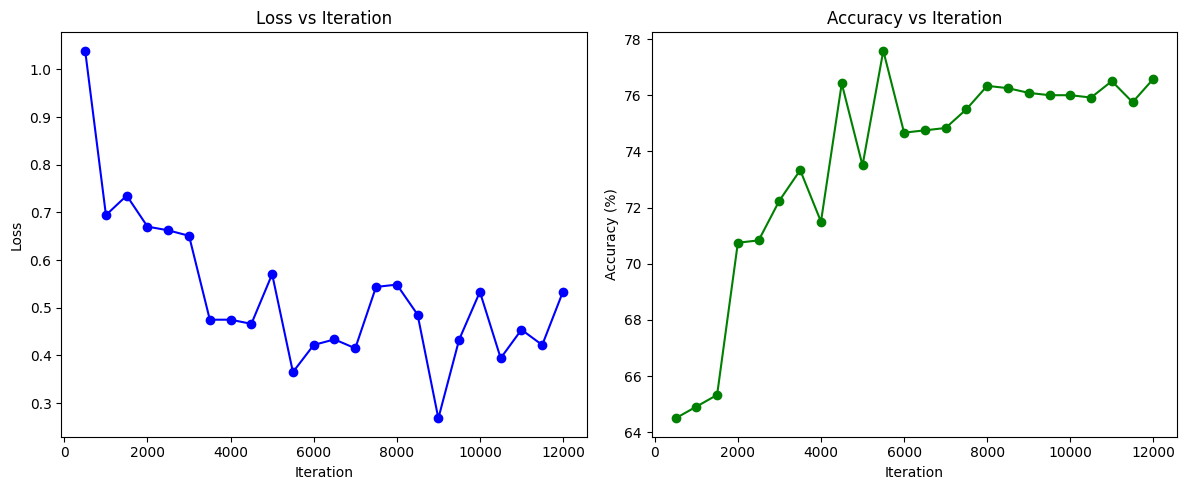

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(iteration_history, loss_history, marker='o', color='blue')
plt.title('Loss vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(iteration_history, accuracy_history, marker='o', color='green')
plt.title('Accuracy vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

In [16]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

    # Tính toán confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)
    
    # In báo cáo classification bao gồm precision, recall, F1-score
    # Giả sử train_set.classes chứa tên các lớp
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_set.classes))

Confusion Matrix:
[[208  55  27  10]
 [ 29 262   2   7]
 [ 41  30 224   5]
 [ 57  15  12 216]]

Classification Report:
                        precision    recall  f1-score   support

   bào ngư xám + trắng       0.62      0.69      0.66       300
        linh chi trắng       0.72      0.87      0.79       300
                nấm mỡ       0.85      0.75      0.79       300
Đùi gà Baby (cắt ngắn)       0.91      0.72      0.80       300

              accuracy                           0.76      1200
             macro avg       0.77      0.76      0.76      1200
          weighted avg       0.77      0.76      0.76      1200



In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np